# 배깅

배깅(Bagging)은 Bootsrap aggregating의 줄임말. 배깅은 중복을 허용한 랜덤 샘플링으로 만든 룬현세트를 사용하여 분류기를 각기 다르게 학습시킴. 부트스트랩 샘플을 만드는 것은 앞서 살펴본 랜덤 포레스트의 특징과 같음.

In [25]:
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import IPython
import sklearn
import mglearn
from preamble import *
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import make_moons
from sklearn.datasets import load_breast_cancer

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = tts(Xm,ym,stratify=ym,random_state=42)

cancer = load_breast_cancer()
Xc_train , Xc_test, yc_train, yc_test = tts(cancer.data, cancer.target, random_state=0)

In [29]:
# 배깅을 사용하여 cancer 데이터셋에 로지스틱 회귀모델을 100개 훈련하여 앙상블 해보기
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(LogisticRegression(), 
                            n_estimators=100,   # 분류기의 개수 100개 
                            oob_score=True,    # True 이면 부스트스트래핑에 포함되지 않은 샘플을 기반으로 훈련된 모델을 평가. 기본값 F
                                               # 이 값을 OOB->Out Of Bagging 오차라고 함. OOB_score 값을 통해 테스트셋의 성능을 짐작가능
                            n_jobs=-1,        # 계산시 사용하는 코어 갯수-1이면 컴퓨터의 모든 코어를 다 사용하여 계산 . 기본값 1          
                            random_state=42)  
bagging.fit(Xc_train,yc_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='warn', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=42, verb

In [30]:
print("train set accuracy: {:.3f}".format(bagging.score(Xc_train,yc_train)))
print("test set accuracy: {:.3f}".format(bagging.score(Xc_test,yc_test)))
print("OOB sample accuracy: {:.3f}".format(bagging.oob_score_))

train set accuracy: 0.962
test set accuracy: 0.958
OOB sample accuracy: 0.948


In [31]:
from sklearn.tree import DecisionTreeClassifier
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=5, n_jobs=-1, random_state=42)
bag.fit(Xm_train,ym_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

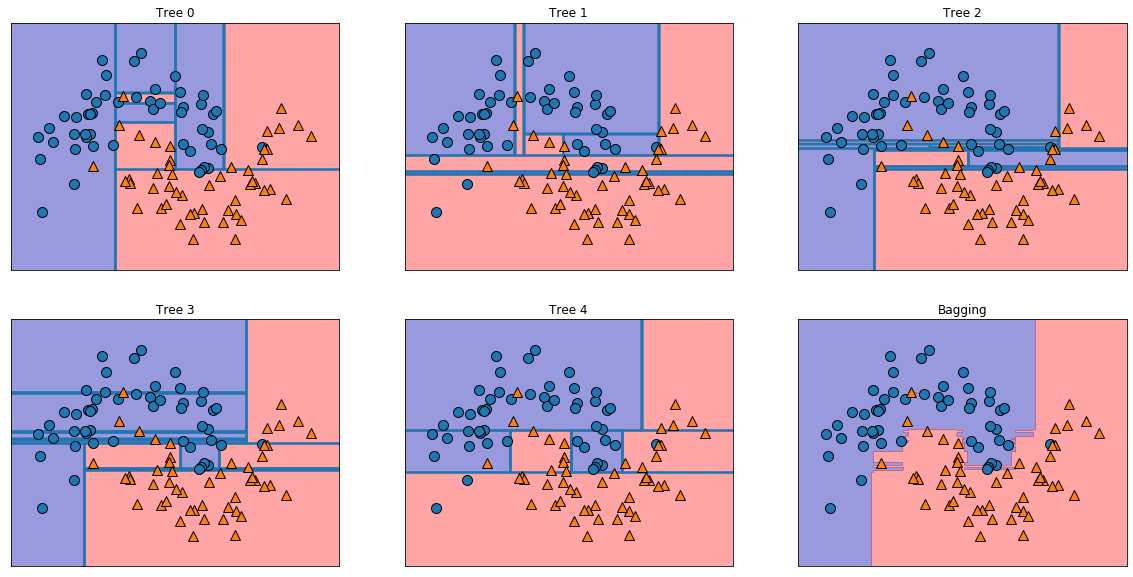

In [38]:
fig, axes = plt.subplots(2,3,figsize=(20,10))
for i, (ax,tree) in enumerate(zip(axes.ravel(),bag.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm,ym,tree,ax=ax)
    
mglearn.plots.plot_2d_separator(bag,Xm,fill=True,ax=axes[-1,-1],alpha=0.4)
axes[-1,-1].set_title("Bagging")
mglearn.discrete_scatter(Xm[:,0], Xm[:, 1], ym)
plt.show()

In [39]:
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
bag.fit(Xc_train,yc_train)

print("train set accuracy: {:.3f}".format(bag.score(Xc_train,yc_train)))
print("test set accuracy: {:.3f}".format(bag.score(Xc_test,yc_test)))
print("OOB sample accuracy: {:.3f}".format(bag.oob_score_))

train set accuracy: 1.000
test set accuracy: 0.965
OOB sample accuracy: 0.951


배깅은 래덤 포레스트와 달리 max_samples 매개변수에서 부트스트랩 샘플의 크기를 지정 할 수 있음. 또한 랜덤 포레스트는 DecisionTreeClassifier(splitter='best')를 사용하도록 고정되어 있음. 결정 트리를 splitter='random' 으로 설정하면 무작위로 분할한 후보 노드 중에서 최선의 분할을 찾음. 이런 결정 트리의 배깅 앙상블은 엑스트라 트리와 큰 관련이 있음.

# 엑스트라 트리

엑스트라 트리는 랜덤 포레스트와 비슷하지만 후보 특성을 무작위로 분할한 다음 최적의 분할을 찾는다. DecisiomTreeClassifier(splitter='random') 을 사용하고 부트스트랩 샘플링은 적용하지 않음. 무작위성을 증가시키면 일반적으로 모델의 편향이 늘어나지만 분사이 감소한다. 엑스트라 트리와 랜덤 포레스트는 다른 방식으로 모델에 무작위성을 주입한다고 볼 수 있다. 예측방식은 랜덤 포레스트와 동일.

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
xtree = ExtraTreesClassifier(n_estimators=5, n_jobs=-1, random_state=0)
xtree.fit(Xm_train, ym_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
                     oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

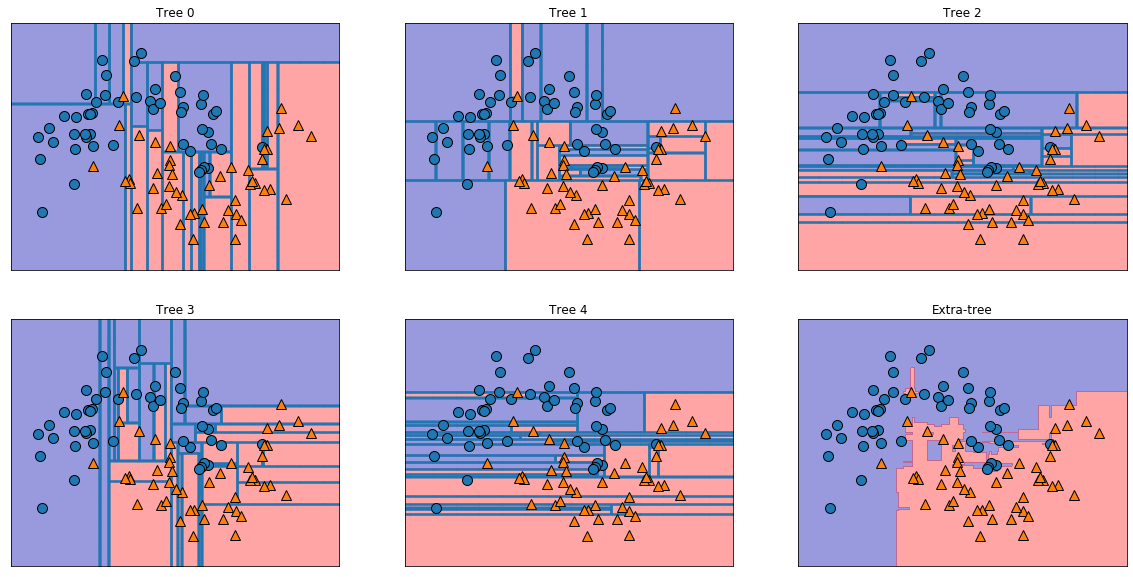

In [43]:
fig, axes = plt.subplots(2,3,figsize=(20,10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), xtree.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm,ym,tree,ax=ax)
    
mglearn.plots.plot_2d_separator(xtree,Xm,fill=True, ax=axes[-1,-1], alpha=0.4)
axes[-1,-1].set_title("Extra-tree")
mglearn.discrete_scatter(Xm[:,0],Xm[:,1],ym)
plt.show()

In [44]:
xtree = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0).fit(Xc_train,yc_train)
print("train set accuracy: {:.3f}".format(xtree.score(Xc_train,yc_train)))
print("test set accuracy: {:.3f}".format(xtree.score(Xc_test,yc_test)))

train set accuracy: 1.000
test set accuracy: 0.972


엑스트라 트리는 랜덤 포레스트와 거의 같은 성능을 냄. 엑스트라 트리가 랜덤 포레스트보다 계산 비용이 비교적 적지만 무작위 분할 때문에 일반화 성능을 높이려면 많은 트리를 만들어야함. 일반적으로 랜덤 포레스트가 더 선호되는 이유이다.

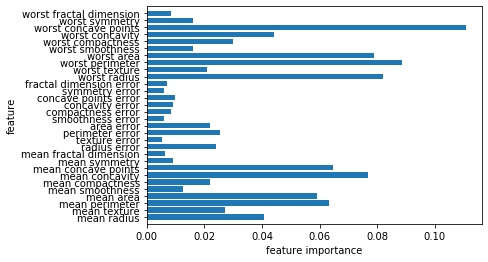

In [45]:
n_features = cancer.data.shape[1]
plt.barh(range(n_features), xtree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("feature importance")
plt.ylabel("feature")
plt.ylim(-1, n_features)
plt.show()

# AdaBoost

에이다부스트는 Adaptive Boosting의 줄임말. 에이다부스트는 그레이디언트 부스팅처럼 약한 학습기를 사용. 그레이디언트 부스팅과는 달리 이전의 모델이 잘못 분류한 샘플에 가중치를 높여서 다음 모델을 훈련시킨다. 훈련된 각 모델은 성능에 띠리 가중치가 부여됨. 예측을 만들 때는 모델의 가중치를 합산하여 가장 높은 값을 가진 레이블을 선택.

AdaBoostClassifier 는 기본값으로 DecisionTreeClassifier(max_depth=1)을 사용하고 AdaBoostRegressor는 DecisionTreeRegressor(max_depth=3)을 사용하지만 base_estimator 매개변수에서 다른 모델을 지정할 수도 있음. 그레이디언트 부스팅과 마찬가지로 순차적으로 학습해야 하기 때문에 n_jobs 매개변수를 지원하지 않음. 

In [46]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=5, random_state=42).fit(Xm_train, ym_train)

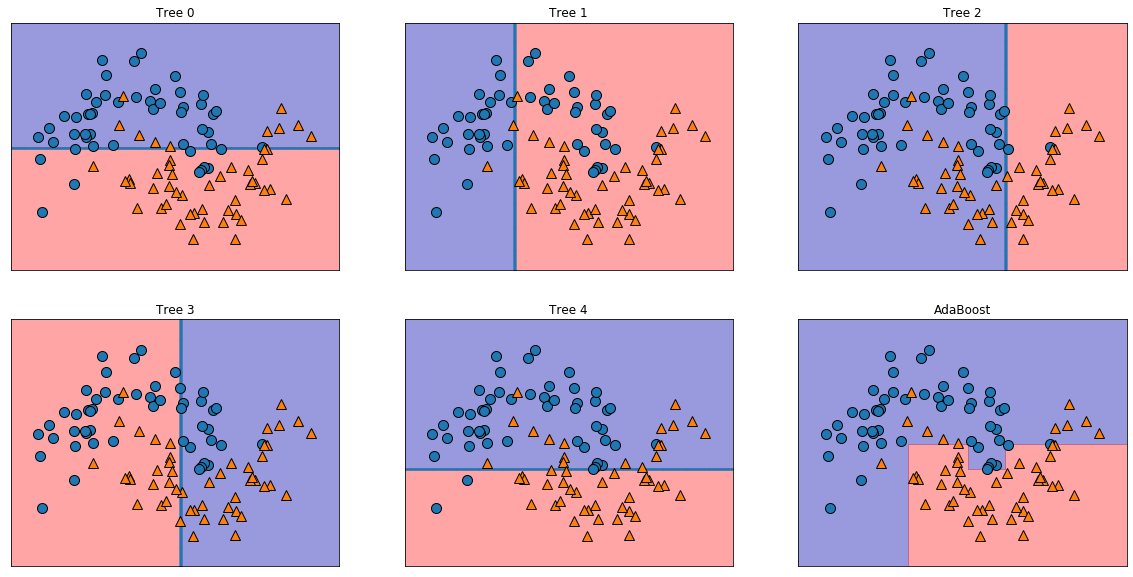

In [47]:
fig, axes = plt.subplots(2,3,figsize=(20,10))
for i, (ax,tree) in enumerate(zip(axes.ravel(), ada.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(ada, Xm, fill=True, ax=axes[-1,-1], alpha=.4)
axes[-1,-1].set_title("AdaBoost")
mglearn.discrete_scatter(Xm[:,0],Xm[:,1], ym)
plt.show()

AdaBoostClassifier 는 깊이가 1인 결정트리를 사용하기 때문에 각 트리의 결정 경계가 직선 하나이다. 앙상블된 결정 경계도 다른 앙상블 모델에 비해 좀 더 단순함.

In [48]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42).fit(Xc_train,yc_train)
print("train set accuracy: {:.3f}".format(ada.score(Xc_train,yc_train)))
print("test set accuracy: {:.3f}".format(ada.score(Xc_test,yc_test)))

train set accuracy: 1.000
test set accuracy: 0.986


아주 얕은 트리를 앙상블 했기 때문에 일반화 성능이 조금 더 향상됨.

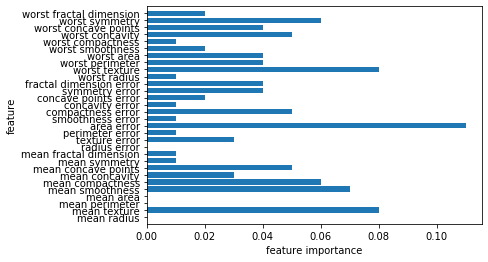

In [49]:
plt.barh(range(n_features), ada.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("feature importance")
plt.ylabel("feature")
plt.ylim(-1,n_features)
plt.show()

에이다부스트의 특성 중요도를 확인해보면 다른 모델에서 부각되지 않았던 'area error' 특성을 크게 강조함.